# Using OpenStreetMap and OverPass API to retrieve geographic data

Useful links:
1. Overpass API Playground: http://overpass-turbo.eu
1. OSM official website: https://www.openstreetmap.org
1. Tags information: https://taginfo.openstreetmap.org
1. JSON visualizer: http://jsonviewer.stack.hu

# Installing dependencies

Uncomment the below line to install required dependencies

In [1]:
#%pip install requests pandas numpy matplotlib folium openrouteservice requests-cache routingpy > /dev/null

In [2]:
import datetime
import folium
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests_cache
import warnings
from routingpy import ORS

warnings.filterwarnings('ignore')

%matplotlib inline

## Querying Overpass API

The OverPass API enables us to query data from OpenStreetMap, an open project maintained by contributors all around the world that contains data related to roads, trails, cafes, supermarkets, railway stations and much more.

In [3]:
overpass_url = "http://overpass-api.de/api/interpreter"

session = requests_cache.CachedSession(
  '.overpass_cache',
  use_cache_dir=True,
  cache_control=True,
  expire_after=datetime.timedelta(days=30),
  allowable_methods=['GET'],
  allowable_codes=[200],
  stale_if_error=True
)

def do_request(overpass_query):
    response = session.get(overpass_url,
                           params={'data': overpass_query})
    return response.json()

def query_arround_cities(adjacent_node_query):
    """Query Adjacent nodes near city centres."""
    query_template = """
[out:json];

area["ISO3166-1"="IE"][admin_level=2];

(
  node[~"place"~"(city|town|village)"](area);
)->.cities;

foreach->.city(
  .city out;
  node(around.city:2500)->.adjacent_set;
  (
    {}
  );
  out meta;
);"""
    return do_request(query_template.format(adjacent_node_query))

def list_amenities():
    """Query for Amenities within 2.5km radius from all city, towns and village centers in Ireland"""
    return query_arround_cities('node.adjacent_set[amenity];')


def list_shops():
    """Query for all Supermarkets within 2.5km radius from all city, towns and villages centers in Ireland"""
    return query_arround_cities('node.adjacent_set[shop];')

Running query for amenities (this takes a while).

In [4]:
amenities = list_amenities()

Running query for supermarkets.

In [5]:
shopes = list_shops()

The output of both queries will return a list of nodes, where the first node

In [6]:
def per_city(data, tag):
    """Format data to list"""
    cities = []
    items = []
    city = ''
    for node in data['elements']:
        tags = node['tags']
        
        if 'place' in node['tags']:
            # this is a city node
            city = node['tags']['name']
            cities.append({
                'id': node['id'],
                'lat': node['lat'],
                'lon': node['lon'],
                'name': tags['name'],
                'type': 'city'
            })
            continue

        # this is a non city node
        items.append({
            'id': node['id'],
            'lat': node['lat'],
            'lon': node['lon'],
            'name': tags['name'] if 'name' in tags else None,
            'city': city,
            'type': f"{tag}_{tags[tag]}" if tag in tags else None
        })
    return items, cities

data_amenities, cities = per_city(amenities, 'amenity')
df_amenities = pd.DataFrame(data_amenities).set_index('id')

data_shops, cities = per_city(shopes, 'shop')
df_shops = pd.DataFrame(data_shops).set_index('id')

In [7]:
df = df_amenities.append(df_shops, ignore_index=True)

## Finding Points of Interest

Build data frame with cities only

In [8]:
df_poi = df.copy()
df_poi = df_poi.join(pd.get_dummies(df_poi['type']))
df_poi.drop(columns=['type'], inplace=True)
df_poi.drop(columns=['name'], inplace=True)
df_poi.drop(columns=['lat', 'lon'], inplace=True)
df_poi = df_poi.sort_values(df_poi.columns.tolist(), ascending=False)
df_poi = df_poi.groupby(['city']).sum()
df_poi.columns.tolist()

['amenity_animal_boarding',
 'amenity_animal_breeding',
 'amenity_animal_hitch',
 'amenity_animal_shelter',
 'amenity_arts_centre',
 'amenity_atm',
 'amenity_bank',
 'amenity_bar',
 'amenity_bbq',
 'amenity_bench',
 'amenity_bicycle_parking',
 'amenity_bicycle_rental',
 'amenity_bicycle_repair_station',
 'amenity_bicycle_repair_station;bench',
 'amenity_biergarten',
 'amenity_binoculars',
 'amenity_boat_rental',
 'amenity_boat_storage',
 'amenity_box_office',
 'amenity_bts',
 'amenity_bureau_de_change',
 'amenity_bus_station',
 'amenity_cafe',
 'amenity_cafe;restaurant',
 'amenity_car_rental',
 'amenity_car_sharing',
 'amenity_car_wash',
 'amenity_casino',
 'amenity_charging_station',
 'amenity_childcare',
 'amenity_cinema',
 'amenity_clinic',
 'amenity_clock',
 'amenity_coast_guard',
 'amenity_college',
 'amenity_community_centre',
 'amenity_compressed_air',
 'amenity_conference_centre',
 'amenity_courthouse',
 'amenity_coworking_space',
 'amenity_crematorium',
 'amenity_dentist',
 'a

In [9]:
amenities_of_interrest = [f"amenity_{x}" for x in ['pharmacy', 'atm', 'restaurant', 'pub', 'fuel']]
shops_of_interrest = [f"shop_{x}" for x in ['supermarket']]

filtered = df_poi.copy()
for i in amenities_of_interrest:
    filtered = filtered[filtered[i] > 0]
for i in shops_of_interrest:
    filtered = filtered[filtered[i] > 2]

filtered = filtered.sort_values(amenities_of_interrest + shops_of_interrest, ascending=False)
filtered.head()

,amenity_animal_boarding,amenity_animal_breeding,amenity_animal_hitch,amenity_animal_shelter,amenity_arts_centre,amenity_atm,amenity_bank,amenity_bar,amenity_bbq,amenity_bench,...,shop_watches,shop_water_sports,shop_wedding,shop_wholesale,shop_wigs,shop_window_blind,shop_wine,shop_wool,shop_yes,shop_yes;gift
city,,,,,,,,,,,,,,,,,,,,,
Cork,0.0,1.0,0.0,0.0,2.0,16.0,22.0,29.0,0.0,134.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0
Limerick,0.0,0.0,0.0,0.0,2.0,15.0,14.0,5.0,0.0,26.0,...,0.0,0.0,0.0,6.0,0.0,2.0,2.0,0.0,28.0,0.0
Goatstown,0.0,0.0,0.0,0.0,0.0,25.0,9.0,5.0,0.0,124.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0
Rathfarnham,0.0,0.0,0.0,0.0,1.0,13.0,5.0,0.0,0.0,54.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,6.0,0.0
Blackrock,0.0,0.0,0.0,0.0,0.0,12.0,8.0,2.0,0.0,117.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,7.0,0.0


In [10]:
cities_of_interest = filtered.index.tolist()
len(cities_of_interest)

42

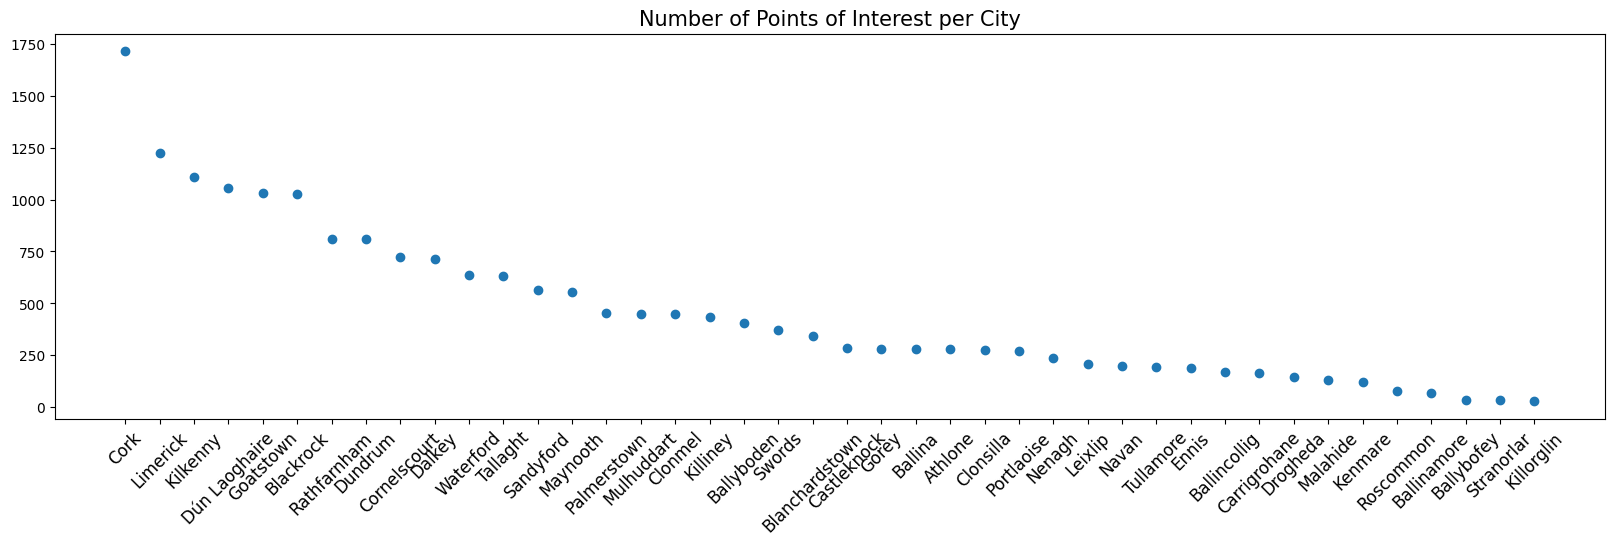

In [11]:
plt.figure(figsize=(20, 5))
to_plot = df[df.city.isin(filtered.index)].groupby('city').count()['type'].sort_values(ascending=False)
plt.scatter(to_plot.index, to_plot)
plt.xticks(ticks=to_plot.index, labels=to_plot.index, rotation=45, fontsize=12)
plt.title('Number of Points of Interest per City', fontdict={'size': 15})
plt.show()

## Check distance of each city to Dublin

In [13]:
dublin = [n for n in cities if n['name'] == 'Dublin'][0]
dublin_pos = [dublin['lat'], dublin['lon']]

### Plot cities

In [14]:
m = folium.Map(location=(53.305494, -7.737649), tiles='cartodbpositron', zoom_start=8, no_touch=True, zoom_control=False)
for city in cities:
    if city['name'] in cities_of_interest:
        folium.Marker(
            location=[city['lat'], city['lon']], 
            popup=city['name']).add_to(m)
m

## Rent Offers

In [39]:
daft = pd.read_csv('data/daft.csv', index_col='id')

In [ ]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
    return c * r

In [79]:
coordenates = daft[['point_lat', 'point_lon']]
coordenates.drop_duplicates(inplace=True)

In [80]:
daft_indexes = coordenates.index.tolist()
df_distances = pd.DataFrame(columns=daft_indexes, index=daft_indexes)

In [82]:
for x in daft_indexes:
    for y in daft_indexes:
        if x == y:
            df_distances.loc[x, y] = 0
        elif pd.isna(df_distances.loc[x, y]) and pd.isna(df_distances.loc[y, x]):
            df_distances.loc[x, y] = haversine(
                coordenates.loc[x, 'point_lon'], coordenates.loc[x, 'point_lat'],
                coordenates.loc[y, 'point_lon'], coordenates.loc[y, 'point_lat'])

In [33]:
m = folium.Map(location=(53.305494, -7.737649), tiles='cartodbpositron', zoom_start=8, no_touch=True, zoom_control=False)
for line in daft.iterrows():
    index, values = line
    folium.Marker(
        location=[values['point_lat'], values['point_lon']], 
        popup=values['price']).add_to(m)
m

In [ ]:
filtered.to_csv('data/ireland_cities.csv')